# CS596 Machine Learning 
# Assignment 8 (Part 2): <br>Kmeans -- Applying clustering algorithm on image data

### Due 11:59 pm, Friday, 12/13/2019

**Total points: 5**

In this assignment, you will practice implementing K-means clustering, and then apply it on a subset of sign language dataset.

The `PCA` module provided by `sklearn` package will be used for pre-clustering analysis and post-clustering visualization. You can install `sklearn` by running the following command in terminal:

```
$ pip install sklearn
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

np.random.seed(1)
%matplotlib inline

## Load data

Load data and preprocess.

In [2]:
X_all = np.load(open('X_train.npy', 'rb'))

X1 = X_all[:163, :]
X2 = X_all[163:327, :]
X3 = X_all[327:491, :]

X = np.concatenate((X1, X2, X3), axis=0)
X = np.transpose(X, (1,2,3,0)).reshape(-1, X.shape[0])
print('Shape of X:', X.shape)

Shape of X: (4096, 491)


---
## Analysis

First, we reduce and dimension of the original data to 2, and plot it. The goal of this step is to have some clues of what $k$ values to use, i.e., the number of clusters.

We know that image data of 3 classes are selected, but we use them as if they are unlabelled. Judging from the 2-D plot, there are quite amount of outliers in data, and choosing $k=3$ may well group those outliers into a cluster, instead of grouping into the correct classes. For this we will find out at the last step.

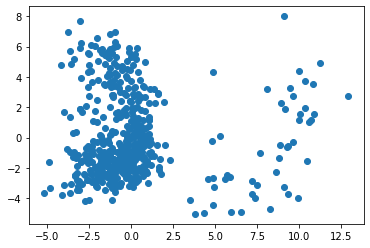

In [3]:
pca = PCA(n_components=2)
pca.fit(X.T)
X_proj = pca.transform(X.T)

# Plot
fig = plt.figure()
plt.scatter(X_proj[:,0], X_proj[:,1])
plt.show()

---
## Task 1. Initialize centroids
**0.5 points**

The first step of k-means is to randomly initialize a set of centroids. To accomplish this, we simply select $k$ out of the $m$ data points randomly.

**Instructions:**
- Data are stored in columns in `X`. We draw `k` random columns out of it by calling `numpy.random.choice()`. Notice that use the argument `replace=False` is important. Otherwise, it is possible to sample repeated points.
- The returned `centroids` are in shape (n, k).

In [4]:
# Initialize centroids
def init_centroids(X, k):
    """
    Args:
    X -- data, shape (n, m)
    k -- number of clusters
    
    Return:
    centroids -- k randomly picked data points as initial centroids, shape (n, k)
    """
    assert(k > 1)
    np.random.seed(1)
    
    ### START YOUR CODE ###
    columns_index = np.random.choice(range(X.shape[1]), size = k , replace = False)
    centroids = X[:, columns_index]
    ### END YOUR CODE ###
    
    return centroids

In [5]:
# Evaluate Task 1
np.random.seed(1)
X_tmp = np.random.randn(4, 10)
c = init_centroids(X_tmp, k=3)

print('Shape of centroids:', c.shape)
print('centroids:', c)

c_expanded = np.expand_dims(c, axis=1)
print(c_expanded.shape)
print(X_tmp.T.shape)
print(c_expanded.T.shape)
print((X_tmp.T - c_expanded.T).shape)

Shape of centroids: (4, 3)
centroids: [[-0.52817175 -0.24937038  1.74481176]
 [-0.3224172   0.58281521 -0.17242821]
 [ 0.90159072  0.53035547 -0.12289023]
 [-0.6871727   0.74204416 -1.11731035]]
(4, 1, 3)
(10, 4)
(3, 1, 4)
(3, 10, 4)


### Expected output

|&nbsp;|&nbsp; |          
|--|--|
|**Shape of centroids:**|(4, 3)|
|**centroids:**|[[-0.52817175 -0.24937038  1.74481176]<br>[-0.3224172   0.58281521 -0.17242821]<br>[ 0.90159072  0.53035547 -0.12289023]]<br>[-0.6871727   0.74204416 -1.11731035]|

***

## Task 2. Compute distance between data points and centroids
**1 point**

Next, we need to compute the distances between data points and centroids. More concretely, for each data point `X[:,i]`, we need to compute its distance from the $k$ centroids, i.e., `centroids[:, j]` ($j=1,2,\dots,k$). We will store the computed distances in a $k\times m$ array, in which the element at position $(j, i)$ is the distance between `X[:,i]` and `centroids[:,j]`. The distance we talk about here is Euclidean distance.

There are multiple ways of implementing this computation. The most efficient way is as follows:
- First, expand `centroids` by adding one demension to it, so that its shape changes from (n, k) to (n, 1, k). This can be done by calling `np.expand_dims()`.
- Second, transpose `X` and `centroids_expanded`. The former has shape (m, n) and the latter has shape (k, 1, n). Then the subtraction `S = X.T - centroids_expanded.T` will be in shape (k, m, n). For why it is the case, read the documentation about the broadcasting mechanism of numpy __[here](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.broadcast.html)__. 
Next, following the definition of Euclidean distance, we need to:
    - Compute `S**2`, which is in shape (k, m, n).
    - Sum over `S**2` along `axis=2`, which eliminate the last dimension.
    - Apply `numpy.sqrt()` to `S**2`, resulting in an array of shape (k, m), which gives the Euclidean distances.

If you found the above method hard to follow, you can also use an explicit for loop to do the computation.
- You create an empty array `distances` of shape (k, m).
- Then you use a for loop, `for j in range(k):`, and in each step, you compute `S = X - centroids[:,j]` followed by `S**2`, `numpy.sum()`, and `numpy.sqrt()` to get the Euclidean distance, which is stored in a (1,m) array `d`. Then you copy `d` back to the `j`th row of `distances`.

In [6]:
# Compute distances
def compute_distances(X, centroids):
    """
    Args:
    X -- data, shape (n, m)
    centroids -- shape (n, k)
    
    Return:
    distances -- shape (k, m)
    """
    ### START YOUR CODE ###
    centroids_expanded = np.expand_dims(centroids, axis = 1)
    S = X.T - centroids_expanded.T 
    distances = np.sqrt(np.sum(S**2, axis = 2))
    ### END YOUR CODE ###
    
    return distances

In [7]:
# Evaluate Task 2
np.random.seed(1)
X_tmp = np.random.randn(4, 5)
c = init_centroids(X_tmp, k=2)

dists = compute_distances(X_tmp, c)
print('Distances:', dists)

Distances: [[3.19996571 3.13120276 0.         1.52120576 2.54127667]
 [5.88553536 0.         3.13120276 2.25851302 4.11463616]]


### Expected output

|&nbsp;|&nbsp; |          
|--|--|
|**Distances:**|[[3.19996571 3.13120276 0.         1.52120576 2.54127667]<br>[5.88553536 0.         3.13120276 2.25851302 4.11463616]]|

***

## Task 3. Find the closest centroid for each data point
**0.5 point**

Given the distances computed, we can find the closest centroid for each data point. We store this information in a $1\times m$ array, and each element is the index of the closest centroid, i.e., an integer ranging from $0$ to $k-1$.

**Instructions:**
- You can apply `numpy.argmin()` on the `distances` computed in previous step as input, and a proper `axis` argument.

In [8]:
# Find the closest centroid for each data point
def cloeset_centroid(distances):
    """
    Args:
    distances -- numpy array of shape (k, m), output of compute_distances()
    
    Return:
    indices -- numpy array of shape (1, m)
    """
    ### START YOUR CODE ###
    indices = np.argmin(distances, axis = 0)
    ### END YOUR CODE ###
    
    return indices

In [9]:
# Evaluate Task 3
np.random.seed(1)
X_tmp = np.random.randn(4, 5)
c = init_centroids(X_tmp, k=2)

dists = compute_distances(X_tmp, c)
closest_indices = cloeset_centroid(dists)

print('Indices of the cloest centroids:', closest_indices)

Indices of the cloest centroids: [0 1 0 0 0]


### Expected output

|&nbsp;|&nbsp; |          
|--|--|
|**Indices of the cloest centroids:**|[0 1 0 0 0]|

***

## Task 4. Update centroids
**1.5 points**

Given the indices of closest centroid for each data point, you need to update the centroids by computing the average positions of the data points belonging to each cluster ($1,2,\dots,k$).

**Instructions:**
- Because `closest_indices` (output of `closes_centroid()`) is of shape (1, m), you can access the data points whose closest centroid is `j` by using the slice `X[:, closest_indices==j]`.
- Pay attention to the dimension of `new_centroids` computed, and it needs to be the same as `centroids`.

In [10]:
# Update centroids
def update_centroids(X, closest_indices, centroids):
    """
    Args:
    X -- data, shape (n, m)
    cloesest_indices -- output of closest_centroid()
    centroids -- old centroids positions
    
    Return:
    new_centroids -- new centroids positions, shape (n, k)
    """
    ### START YOUR CODE ### 
    new_centroids = np.array([np.mean(X[:, closest_indices==j], axis=1) for j in range(centroids.shape[1])]).T
    ### END YOUR CODE ###
    
    assert(centroids.shape == new_centroids.shape)
    
    return new_centroids

In [11]:
# Evaluate Task 4
np.random.seed(1)
X_tmp = np.random.randn(4, 5)
c = init_centroids(X_tmp, k=2)

dists = compute_distances(X_tmp, c)
closest_indices = cloeset_centroid(dists)
new_c = update_centroids(X_tmp, closest_indices, c)

print('New centroids:', new_c)

New centroids: [[ 0.22215315 -0.61175641]
 [-0.74826922  1.74481176]
 [ 0.47235146 -2.06014071]
 [-0.33818018 -0.17242821]]


### Expected output

|&nbsp;|&nbsp; |          
|--|--|
|**New centroids:**|[[ 0.22215315 -0.61175641]<br>[-0.74826922  1.74481176]<br>[ 0.47235146 -2.06014071]<br>[-0.33818018 -0.17242821]]|

***

## Task 5. Integrated model
**1.5 points**

Finally, we combine all the previous steps into one model. We repeatedly find the closest centroid for each data points, and then update the centroids, until the centroids no longer change. The final stable `closest_indices` is then the clustering result.

In [12]:
# K-means
def kmeans(X, k):
    """
    Args:
    X -- data, shape (n, m)
    k -- number of clusters
    
    Return:
    closest_indices -- final assignment of clusters to each data point, shape (1, m)
    centroids -- final positions of centroids
    """
    ### START YOUR CODE ###
    centroids = init_centroids(X, k)
    ### END YOUR CODE ###
    
    old_centroids = None
    while not np.array_equal(old_centroids, centroids):
        # Backup centroids
        old_centroids = np.copy(centroids)
        
        ### START YOUR CODE ###
        # Compute distances
        distances = compute_distances(X, centroids)
        
        # Find cloeset centroid
        closest_indices = cloeset_centroid(distances)
        
        # Update centroids
        centroids = update_centroids(X, closest_indices, centroids)
        ### END YOUR CODE ###
    
    return closest_indices, centroids

In [13]:
# Evaluate Task 5
closest_indices, centroids = kmeans(X, 3)

print('closest_indices[:10]', closest_indices[:10])
print('closest_indices[70:80]', closest_indices[70:80])
print('closest_indices[140:150]', closest_indices[140:150])
print('closest_indices[210:220]', closest_indices[210:220])

closest_indices[:10] [1 1 0 0 1 1 1 1 1 0]
closest_indices[70:80] [1 1 1 1 1 1 1 1 1 1]
closest_indices[140:150] [1 1 1 1 1 1 1 1 1 0]
closest_indices[210:220] [2 1 1 1 2 2 2 2 2 2]


### Expected output

|&nbsp;|&nbsp; |          
|--|--|
|**closest_indices[:10]**|[1 1 0 0 1 1 1 1 1 0]|
|**closest_indices[70:80]**|[1 1 1 1 1 1 1 1 1 1]|
|**closest_indices[140:150]**|[1 1 1 1 1 1 1 1 1 0]|
|**closest_indices[210:220]**|[2 1 1 1 2 2 2 2 2 2]|

***

## Visualize clustering result using PCA (ungraded)



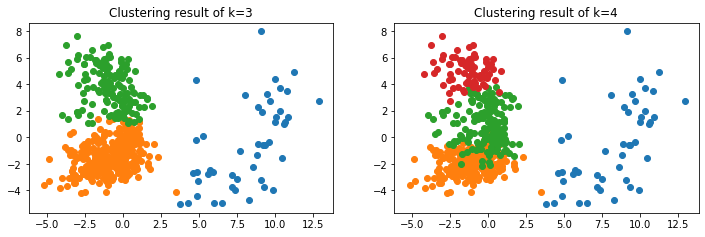

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X.T)
X_proj = pca.transform(X.T)

# Cluster and 
fig = plt.figure(figsize=(12, 3.5))

closest_indices, centroids = kmeans(X, 3)
fig.add_subplot(1, 2, 1)
plt.scatter(X_proj[closest_indices==0, 0], X_proj[closest_indices==0, 1])
plt.scatter(X_proj[closest_indices==1, 0], X_proj[closest_indices==1, 1])
plt.scatter(X_proj[closest_indices==2, 0], X_proj[closest_indices==2, 1])
plt.title('Clustering result of k=3')

closest_indices, centroids = kmeans(X, 4)
fig.add_subplot(1, 2, 2)
plt.scatter(X_proj[closest_indices==0, 0], X_proj[closest_indices==0, 1])
plt.scatter(X_proj[closest_indices==1, 0], X_proj[closest_indices==1, 1])
plt.scatter(X_proj[closest_indices==2, 0], X_proj[closest_indices==2, 1])
plt.scatter(X_proj[closest_indices==3, 0], X_proj[closest_indices==3, 1])
plt.title('Clustering result of k=4')

plt.show()

***
 Let's compare with the ground truth, i.e., labeled data.

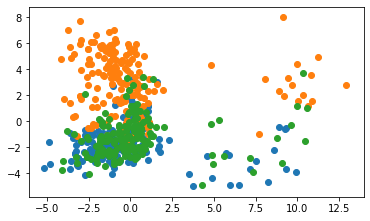

In [15]:
fig = plt.figure(figsize=(6, 3.5))

plt.scatter(X_proj[:163, 0], X_proj[:163, 1])
plt.scatter(X_proj[163:327, 0], X_proj[163:327, 1])
plt.scatter(X_proj[327:491, 0], X_proj[327:491, 1])

plt.show()

Looks like k-means cannot distinguish the 2nd and 3rd classes, and it is also sensitive to outliers.